# Convolutional autoencoder on STFT data

Taken from https://github.com/pkmital/tensorflow_tutorials/blob/master/python/08_denoising_autoencoder.py


In [14]:
from __future__ import division, print_function, absolute_import
%pylab inline
import wget

import tensorflow as tf
import numpy as np
import os
from utils import *


Populating the interactive namespace from numpy and matplotlib


In [15]:
path = "../wavs/"
fname = 'Stockhausen_Kontakte.wav'
fname = 'mipais.wav'

filename = path+fname

fs,x = wav2audio_segment(filename)
S = audio2spectral(x,orig_fs=fs,resample_fs=22050,magnitude=True,representation='STFT',units='db',nfft_size= 2**10,nfft_hop=2**8,
         frame_size=64, n_bins = 64,normalization_axis=None)

Dimensions: data length, freq bins, time bins
372 513 64


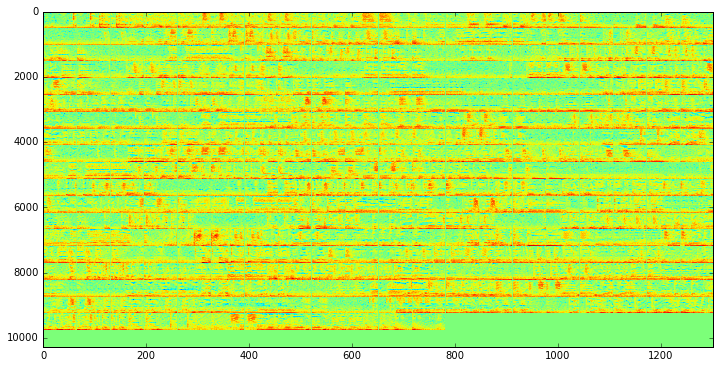

In [16]:
print("Dimensions: data length, freq bins, time bins")
total_length, freq_bins,time_bins = S.shape
print(total_length, freq_bins,time_bins)

# imshow(S[21],aspect='auto',origin='bottom');
figure(figsize=(12,6))
imshow(montage(S),aspect='auto');

In [17]:
train_length = 120
test_length = total_length - train_length
ixs = np.arange(total_length)
np.random.shuffle(ixs)

data = Data( S[ixs[:train_length],:,:].reshape((train_length,freq_bins*time_bins)) )

test = Data( S[ixs[train_length:train_length+test_length],:,:].reshape((test_length,freq_bins*time_bins)) )

In [18]:
mean_img = data.data.mean(0)

batch_size = 60
n_epochs = 300
learning_rate = 0.001
n_filters=[16,16,16]
n_features =  int(data.data.shape[1])
input_shape = [None, n_features]
filter_sizes = [4,4,4]
stri = [1, 2, 2, 1]

In [19]:
input_shape

[None, 32832]

In [20]:
# %%
tf.reset_default_graph()
# input to the network
X = tf.placeholder( tf.float32, input_shape, name='x')

X_tensor = tf.reshape(X, [-1, freq_bins, time_bins, 1])

current_input = X_tensor

# notice instead of having 784 as our input features, we're going to have
# just 1, corresponding to the number of channels in the image.
# We're going to use convolution to find 16 filters, or 16 channels of information in each spatial location we perform convolution at.
n_input = 1

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []
shapes = []
l = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(n_filters):
    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        # we'll keep track of the shapes of each layer
        # As we'll need these for the decoder
        shapes.append(current_input.get_shape().as_list())
        l.append(current_input)
        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input,
                n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll convolve our input by our newly created W matrix
        h = tf.nn.conv2d(current_input, W,
            strides=stri, padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)
        

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

z = current_input
# %%
# store the latent representation
Ws.reverse()
# and the shapes of each layer
shapes.reverse()
# and the number of filters (which is the same but could have been different)
n_filters.reverse()
# and append the last filter size which is our input image's number of channels
n_filters = n_filters[1:] + [1]

print(n_filters, filter_sizes, shapes)

# %%
# Build the decoder using the same weights
for layer_i, shape in enumerate(shapes):
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        l.append(current_input)
        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = Ws[layer_i]

        # Now we'll convolve by the transpose of our previous convolution tensor
        h = tf.nn.conv2d_transpose(current_input, W,
            tf.pack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=stri, padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)
        
l.append(current_input)

# %%
# now have the reconstruction through the network
Y = current_input
Y = tf.reshape(Y, [-1, n_features])
# cost function measures pixel-wise difference
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))

ae = {'X': X, 'z': z, 'Y': Y, 'cost': cost}

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


[16, 16, 1] [4, 4, 4] [[None, 129, 16, 16], [None, 257, 32, 16], [None, 513, 64, 1]]


[16, 16, 1] [4, 4, 4] [[None, 129, 16, 16], [None, 257, 32, 16], [None, 513, 64, 1]]


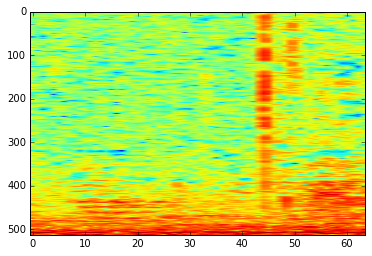

In [21]:
print(n_filters, filter_sizes, shapes)
imshow(data.next_batch(batch_size)[0].reshape((freq_bins,time_bins)),aspect='auto')

In [22]:
# %%
# We create a session to use the graph
config = tf.ConfigProto( device_count = {'GPU': 1} )
sess = tf.Session(config=config)
sess.run(tf.initialize_all_variables())

# %%
# Fit all training data

total_batch = int(data.length/batch_size)
for epoch_i in range(n_epochs):
    for batch_i in range(total_batch):
        batch_xs = data.next_batch(batch_size)

        sess.run(optimizer, feed_dict={ae['X']: batch_xs-mean_img })
    
    if epoch_i%5==0:
        print(epoch_i, sess.run(ae['cost'], feed_dict={ae['X']: batch_xs-mean_img}))

0 0.00526594
5 0.00528932
10 0.00542138
15 0.00533001
20 0.00516705
25 0.00431345
30 0.00407118
35 0.00382315
40 0.00389758
45 0.00387505
50 0.00385086
55 0.00393654
60 0.00374861
65 0.00349772
70 0.00358789
75 0.0035389
80 0.00342594
85 0.00360388
90 0.00351956
95 0.00363553
100 0.00357178
105 0.00347988
110 0.0034994
115 0.00346461
120 0.0034432
125 0.00337483
130 0.00343337
135 0.00338814
140 0.00331829
145 0.00322752
150 0.00340143
155 0.0033399
160 0.00342065
165 0.00317626
170 0.00328273
175 0.0033268
180 0.0031757
185 0.00331911
190 0.00342506
195 0.00327675
200 0.0032864
205 0.00333413
210 0.00326524
215 0.00319617
220 0.00321831
225 0.00314318
230 0.00326596
235 0.00315426
240 0.00336039
245 0.00320053
250 0.00312837
255 0.00330702
260 0.00324627
265 0.00309319
270 0.00319769
275 0.00322374
280 0.00317942
285 0.00327626
290 0.00323423
295 0.00327037


In [23]:
compare = [3,21,46]

recon = sess.run(ae['Y'], feed_dict={ ae['X']: data.data[compare]-mean_img})

recon.shape

(3, 32832)

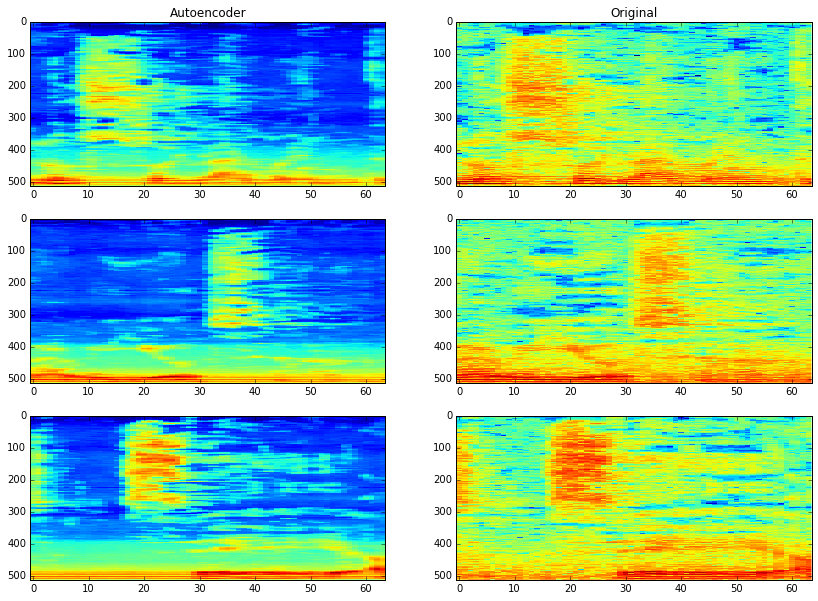

In [24]:
original = data.data[compare]
figure(figsize=(14,10))
for i,c in enumerate(compare):
    
    subplot(len(compare),2,i*2+1)
    imshow(recon[i].reshape(freq_bins,time_bins)+mean_img.reshape(freq_bins,time_bins),aspect='auto',interpolation='none')
    subplot(len(compare),2,i*2+2)
    imshow(original[i].reshape((freq_bins,time_bins)),aspect='auto',interpolation='none')

subplot(len(compare),2,1)
title("Autoencoder")
subplot(len(compare),2,2)
title("Original")

# savefig("results_cqt_dim_"+str(dimensions)+"_cost_"+"{:.4f}.png".format(cost_value))

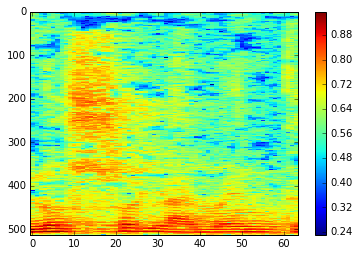

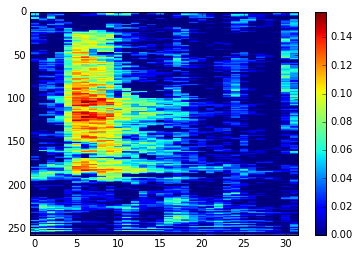

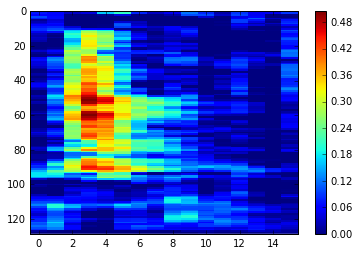

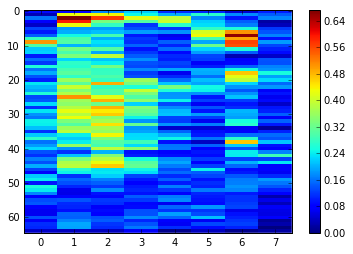

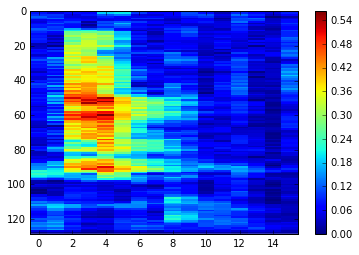

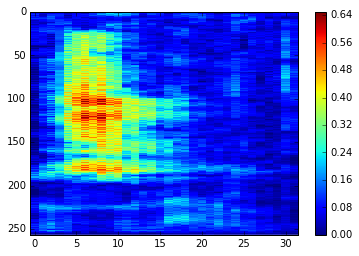

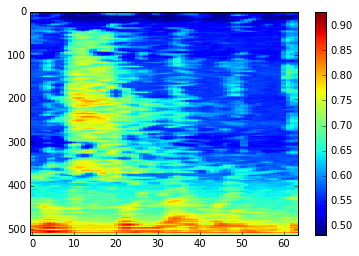

In [30]:
sample = 3

for i,l_ in enumerate(l):
    recon = sess.run(l_, feed_dict={ ae['X']: data.data[sample:sample+1]-mean_img})
    figure()
    
    if i==0 or i== len(l)-1:
        out = recon[0,:,:,0]+mean_img.reshape(freq_bins,time_bins)
    else:
        out = recon[0,:,:,0]
    imshow(out,aspect='auto',interpolation='none')
    
    colorbar()

In [31]:
cost = sess.run(ae['cost'], feed_dict={ae['X']: test.data-mean_img})
print(cost)

0.00327597


In [32]:
import librosa
import librosa.display
import IPython.display

D = out.astype(np.complex128)
# D = data.data[sample]
# D = D.reshape(freq_bins,time_bins).astype(np.complex128)
D = 10**D
D  = librosa.phase_vocoder(D, 1.0, hop_length=512)
audio  = librosa.istft(D, hop_length=512)
IPython.display.Audio(data=audio, rate=fs)

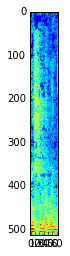

In [28]:
imshow(abs(D))

In [29]:
y, sr   = librosa.load(librosa.util.example_audio_file())
D       = librosa.stft(y, n_fft=2048, hop_length=512)
D = 10**log10(abs(D))
D_fast  = librosa.phase_vocoder(D, 2.0, hop_length=512)
y_fast  = librosa.istft(D_fast, hop_length=512)
IPython.display.Audio(data=y_fast, rate=sr)

/usr/local/lib/python3.4/dist-packages/librosa/core/spectrum.py:585: ComplexWarning: Casting complex values to real discards the imaginary part
  d_stretch[:, t] = mag * np.exp(1.j * phase_acc)
